# What Makes the most Popular Country for Studying Abroad?

### Richard Mu, Shea Chen

## Introduction
### Between the years of 2017 and 2018, a total of 341,751 US students decided to study abroad. The objective of this project is to find a connection between the number of students that decide to study at a particular country and 

In [98]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 


pd.set_option('display.max_rows', 600)   # Set full visualization of dataframes 


travel_data_2017 = pd.read_excel(open('D3A1FE70.xlsx', 'rb'),
                           sheet_name = "data")
travel_data_2017

,Destination,2017/18
0,Cameroon,57
1,Central African Republic,0
2,Chad,2
3,"Congo, Dem. Rep. of (Kinshasa)",6
4,"Congo, Rep. of (Brazzaville)",5
5,Equatorial Guinea,7
6,Gabon,4
7,São Tomé and Príncipe,0
8,Burundi,0
9,Djibouti,0


In [99]:
#https://www.kaggle.com/xenohunter/global-peace-index
peace_index = pd.read_csv('gpi-2008-2019.csv')
peace_index = peace_index[['Country','2017 rank', '2017 score']]
peace_index

,Country,2017 rank,2017 score
0,Iceland,1,1.084
1,New Zealand,2,1.216
2,Portugal,3,1.273
3,Austria,4,1.292
4,Denmark,5,1.299
5,Canada,6,1.332
6,Singapore,12,1.400
7,Slovenia,9,1.373
8,Japan,10,1.377
9,Switzerland,7,1.368


In [100]:
import requests
import re
from bs4 import BeautifulSoup


r = requests.get('https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2017')
root = BeautifulSoup(r.content)

# Find table from html
table = root.find("table", {"id": "t2"})

# Convert to dataframe
cost_living = pd.read_html(str(table))
cost_living = cost_living[0]
cost_living = cost_living[['Country', 'Cost of Living Index']]
cost_living

,Country,Cost of Living Index
0,Bermuda,146.19
1,Switzerland,122.06
2,Iceland,111.71
3,Norway,106.31
4,Bahamas,104.05
5,Us Virgin Islands,85.86
6,Japan,85.28
7,Italy,83.70
8,Denmark,83.02
9,Singapore,82.41


In [101]:
centroids = pd.read_csv('country_centroids_az8.csv')
centroids = centroids[['sovereignt','Longitude','Latitude']]
centroids


,sovereignt,Longitude,Latitude
0,Netherlands,-69.982677,12.520880
1,Afghanistan,66.004734,33.835231
2,Angola,17.537368,-12.293361
3,United Kingdom,-63.064989,18.223959
4,Albania,20.049834,41.142450
5,Finland,19.953288,60.214887
6,Andorra,1.560544,42.542291
7,United Arab Emirates,54.300167,23.905282
8,Argentina,-65.179807,-35.381349
9,Armenia,44.929933,40.289526


In [102]:
happiness = pd.read_csv('2017-happiness.csv')
happiness = happiness[['Country','Happiness.Score']]
happiness

,Country,Happiness.Score
0,Norway,7.537
1,Denmark,7.522
2,Iceland,7.504
3,Switzerland,7.494
4,Finland,7.469
5,Netherlands,7.377
6,Canada,7.316
7,New Zealand,7.314
8,Sweden,7.284
9,Australia,7.284


In [106]:
fulldata = pd.merge(left = travel_data_2017,right = peace_index, left_on="Destination", right_on="Country")
fulldata = fulldata[['Destination','2017/18', '2017 score']]
fulldata.columns = ['Country','Student Count','Peace Score']
fulldata = pd.merge(left = fulldata, right = happiness, left_on="Country", right_on="Country")
fulldata = pd.merge(left = fulldata, right = cost_living, left_on="Country", right_on="Country")
fulldata = fulldata.sort_values('Student Count')


fulldata

,Country,Student Count,Peace Score,Happiness.Score,Cost of Living Index
97,Libya,0,3.340,5.525,45.85
32,Belarus,0,2.106,5.569,33.84
93,Syria,0,3.462,3.462,28.31
89,Kuwait,0,1.823,6.105,75.24
95,Algeria,1,2.188,5.872,32.38
85,Iran,2,2.344,4.692,38.26
86,Iraq,3,3.516,4.497,47.04
19,Pakistan,5,3.080,5.269,27.18
50,Moldova,6,1.944,5.838,28.37
92,Saudi Arabia,8,2.346,6.344,48.37


SyntaxError: unexpected EOF while parsing (<ipython-input-79-1ef896f8b5ce>, line 2)

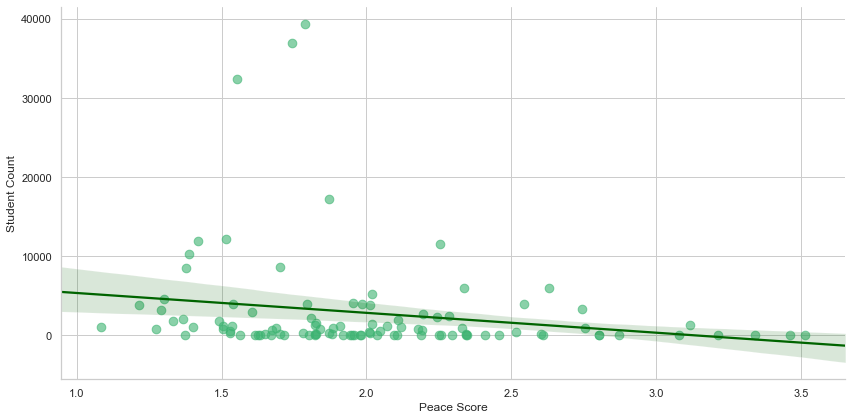

In [89]:
import seaborn as sns
sns.set_style("whitegrid")

#fit, ax = plt.subplots(figsize = (12,10))

peace = sns.lmplot(x='Peace Score', y ="Student Count", size=6, aspect =  2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'mediumseagreen'},
                   line_kws={"color":'darkgreen'},data = fulldata)
peace

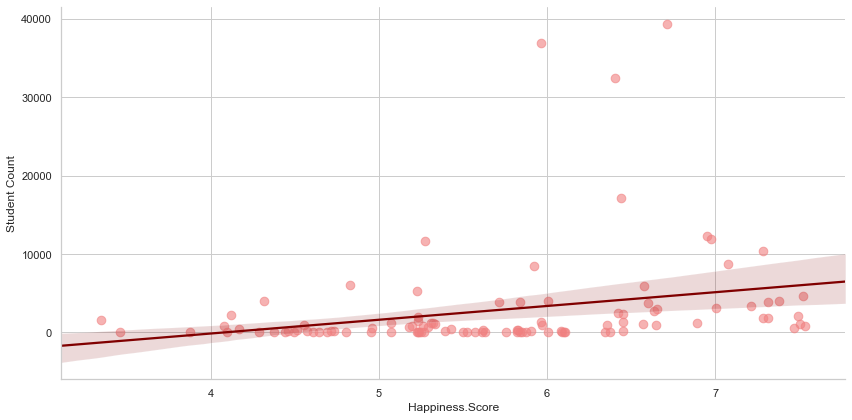

In [90]:
happiness = sns.lmplot(x='Happiness.Score', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'lightcoral'},
                   line_kws={"color":'maroon'},data = fulldata)
happiness

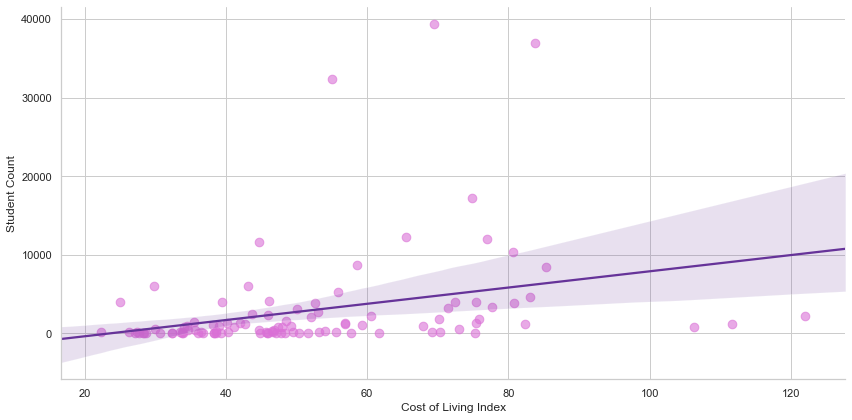

In [141]:
cost = sns.lmplot(x='Cost of Living Index', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'orchid'},
                   line_kws={"color":'rebeccapurple'},data = fulldata)
cost

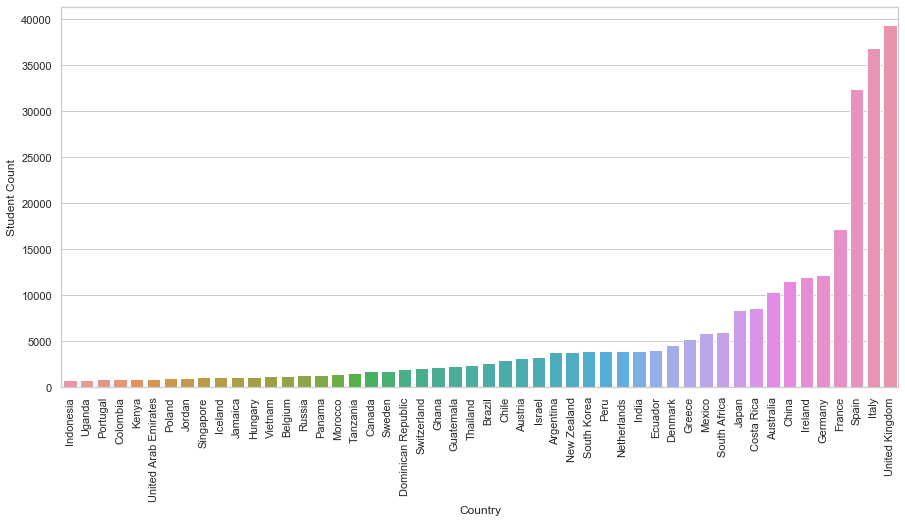

In [134]:
matplotlib.rcParams['figure.figsize']=[15, 7]
plt.xticks(rotation='vertical')


top50 = fulldata.iloc[-50:]
bar_count = sns.barplot( x = "Country", y = "Student Count",data = top50, orient='v')

In [148]:
category = []
catkey = ['2 to 3','3 to 4','4 to 5','5 to 6','6 to 7','7 to 8']
for index, row in fulldata.iterrows():
    if row[3] >= 2 and row[3] < 3:
        category.append('2 to 3')
    if row[3] >= 3 and row[3] < 4:
        category.append('3 to 4')
    if row[3] >= 4 and row[3] < 5:
        category.append('4 to 5')
    if row[3] >= 5 and row[3] < 6:
        category.append('5 to 6')
    if row[3] >= 6 and row[3] < 7:
        category.append('6 to 7')
    if row[3] >= 7 and row[3] < 8:
        category.append('7 to 8')

fulldata['Happiness Category'] = category
    
        

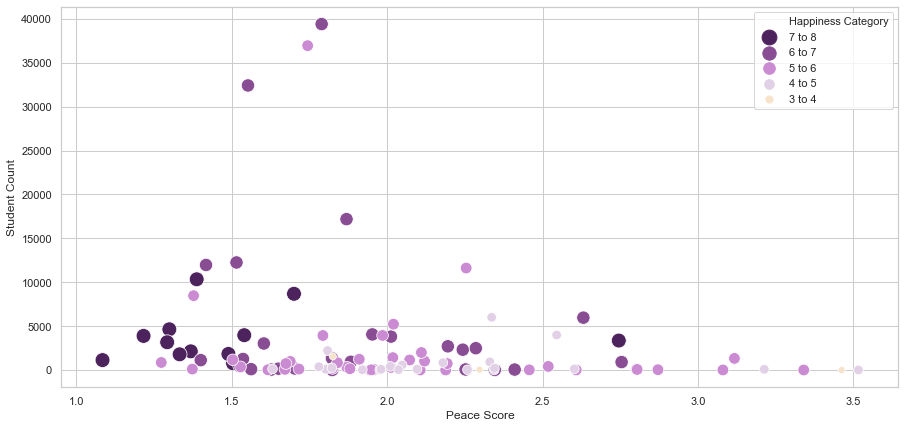

In [172]:
#cmap = sns.cubehelix_palette(dark = .3, light = .8, as_cmap=True)
palette = {"2 to 3":"#FFF8EF","3 to 4":"#F7E3CA", "4 to 5":"#E2D1E6", "5 to 6":"#ca8bd2",
           "6 to 7":"#894d94", "7 to 8":"#4D235D"}

sizesdict = {"2 to 3":2,"3 to 4":4, "4 to 5":6, "5 to 6":8,
           "6 to 7":10, "7 to 8":12}

hap_sort = fulldata.sort_values("Happiness.Score", ascending = False)
hap_peace = sns.scatterplot(x="Peace Score", y="Student Count", hue="Happiness Category",
                            size = "Happiness Category",
                            sizes = (50,220),
                            palette=palette,
                            data = hap_sort)
hap_peace
